|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | -0.001434 | 14.36     | 3.852     | 7.856     | 199.7     |
| 2         | -0.001446 | 8.9       | 1.468     | 2.465     | 266.5     |
| 3         | -0.001428 | 20.03     | 3.124     | 2.165     | 292.5     |
| 4         | -0.00141  | 25.81     | 1.637     | 3.455     | 95.85     |
| 5         | -0.001435 | 12.61     | 2.574     | 5.456     | 122.8     |
| 6         | -0.001415 | 20.3      | 1.418     | 4.337     | 141.6     |
| 7         | -0.001428 | 16.4      | 3.356     | 3.597     | 178.6     |
| 8         | -0.001424 | 19.81     | 1.139     | 6.86      | 92.63     |
| 9         | -0.001487 | 6.626     | 3.847     | 9.725     | 252.1     |
| 10        | -0.001426 | 12.62     | 1.293     | 7.474     | 160.0     |
| 11        | -0.001429 | 29.97     | 3.085     | 3.282     | 109.3     |
| 12        | -0.001432 | 29.73     | 

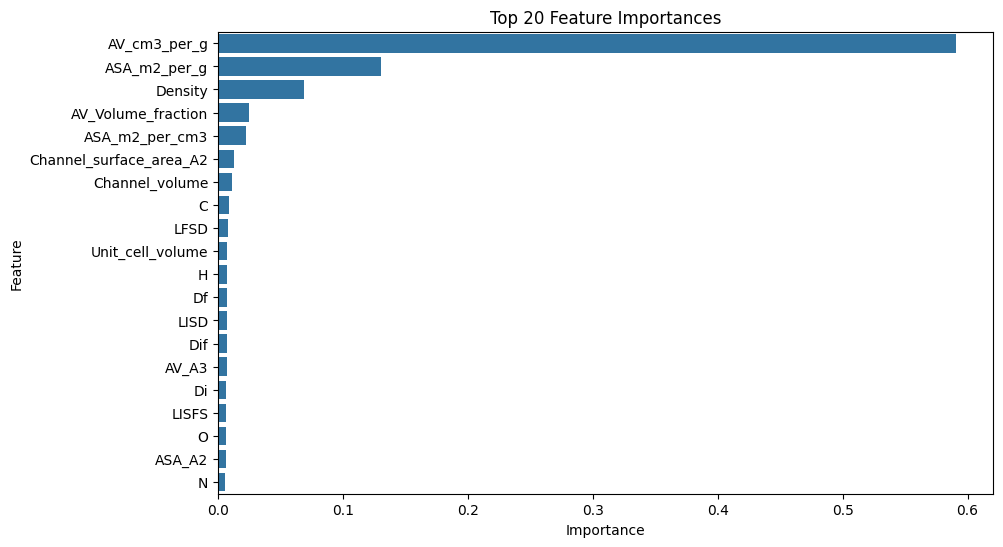

50
Mean Squared Error: 0.0014099786708265747
R2 Score: 0.7962875767965832


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
file_path = 'Combined_set_prescreened.csv'
total_info = pd.read_csv(file_path)

# Data preprocessing
total_info_cleaned = total_info.dropna()
uptake_ads = total_info_cleaned['uptake_ads']
uptake_des = total_info_cleaned['uptake_des']
heat_ads = total_info_cleaned['heat_ads']
heat_des = total_info_cleaned['heat_des']

# Given constants
delta_H_vap_Tev = 16.25          # Example value in kJ/mol
M_w = 0.044097                   # Molar mass in kg/mol
C_sorbent_p = 1                  # Specific heat capacity in kJ/(kg*K)
T_des = 358.15                   # Desorption temperature in Kelvin
T1 = 313.13                      # Initial temperature in Kelvin

# Calculate Δq
delta_q = uptake_ads - uptake_des

# Drop rows with negative Δq
filtered_indices = delta_q >= 0
total_info_cleaned = total_info_cleaned[filtered_indices].copy()
delta_q = delta_q[filtered_indices]

# Calculate <ΔH_ads>
avg_delta_H_ads = (heat_ads + heat_des) / 2
avg_delta_H_ads = avg_delta_H_ads[filtered_indices]

# Calculate COP_R for each row
total_info_cleaned.loc[:, 'COP_R'] = (delta_H_vap_Tev * delta_q) / ((M_w * C_sorbent_p * (T_des - T1)) - (delta_q * avg_delta_H_ads))

# Select target and features
target = total_info_cleaned['COP_R']
features = total_info_cleaned.drop(columns=["MOF", "uptake_ads", "heat_ads", "uptake_des", "heat_des", "Pu", "COP_R"])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.85, random_state=42)

# Function to optimize
def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    rf = RandomForestRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=42
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    return -mean_squared_error(y_test, y_pred)

# Define the parameter bounds
param_bounds = {
    'n_estimators': (50, 300),
    'max_depth': (5, 30),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4)
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=rf_cv,
    pbounds=param_bounds,
    random_state=42
)

# Perform optimization
optimizer.maximize(
    init_points=10,
    n_iter=20
)

# Extract the best parameters
best_params = optimizer.max['params']
best_params = {
    'n_estimators': int(best_params['n_estimators']),
    'max_depth': int(best_params['max_depth']),
    'min_samples_split': int(best_params['min_samples_split']),
    'min_samples_leaf': int(best_params['min_samples_leaf'])
}
print(f"Best parameters found: {best_params}")

# Train the Random Forest Regressor with the best parameters
best_rf = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
best_rf.fit(X_train, y_train)

# Calculate feature importance
importances = best_rf.feature_importances_
feature_names = features.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importances')
plt.show()

# Filter features based on importance threshold
threshold = 0.0005
important_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature'].tolist()
print(len(important_features))

# Select only the important features
X_train_filtered = X_train[important_features]
X_test_filtered = X_test[important_features]

# Train a new Random Forest Regressor with filtered features
rf_filtered = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
rf_filtered.fit(X_train_filtered, y_train)

# Predict on the test set
y_pred = rf_filtered.predict(X_test_filtered)

# Evaluate the model accuracy using mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate other metrics such as R2 score
r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2}")
